<a href="https://colab.research.google.com/github/dattt21/BTL_CSDL-PT/blob/main/BTLcdhttt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math
import datetime
import time

In [ ]:

img_width, img_height = 224, 224

top_model_weights_path = '/content/drive/MyDrive/Data_cdhttt/model/bottleneck_fc_model.h5'

train_data_dir = '/content/drive/MyDrive/Data_cdhttt/train'
validation_data_dir = '/content/drive/MyDrive/Data_cdhttt/validation'
test_data_dir = '/content/drive/MyDrive/Data_cdhttt/test'

# số vòng lặp lại qua dữ liệu
epochs = 15
# đưa vào số mẫu ảnh để thực hiện train
batch_size = 50

In [ ]:
vgg16 = applications.VGG16(include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

# Train 1 lần duy nhất

In [ ]:
## train dữ liệu sử dụng mô hình vgg16, note: chạy 1 lần duy nhất
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
     train_data_dir,
     target_size=(img_width, img_height),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

train_data = vgg16.predict_generator(generator, predict_size_train)

np.save('/content/drive/MyDrive/Data_cdhttt/model_train/train_data.npy', train_data)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 6300 images belonging to 15 classes.


<ipython-input-9-bb4cad89d6ca>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_data = vgg16.predict_generator(generator, predict_size_train)


Time:  1:10:55.894054


In [ ]:
# validation data
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
     validation_data_dir,
     target_size=(img_width, img_height),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False)

nb_validation_samples = len(generator.filenames)

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

validation_data = vgg16.predict_generator(
     generator, predict_size_validation)

np.save('/content/drive/MyDrive/Data_cdhttt/model_train/validation_data.npy', validation_data)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1050 images belonging to 15 classes.


<ipython-input-10-31607611eb0d>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  validation_data = vgg16.predict_generator(


Time:  0:12:36.896520


In [ ]:
#test-data
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
     test_data_dir,
     target_size=(img_width, img_height),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False)

nb_test_samples = len(generator.filenames)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

test_data = vgg16.predict_generator(
     generator, predict_size_test)

np.save('/content/drive/MyDrive/Data_cdhttt/model_train/test_data.npy', test_data)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3150 images belonging to 15 classes.


<ipython-input-11-ddf440aa82ac>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_data = vgg16.predict_generator(


Time:  0:34:52.186009


# load dữ liệu trích xuất

In [ ]:
#training data
generator_top = datagen.flow_from_directory(
         train_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode='categorical',
         shuffle=False)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

train_data = np.load('/content/drive/MyDrive/Data_cdhttt/model_train/train_data.npy')

# lấy nhãn đã được đánh dấu
train_labels = generator_top.classes

# chuyển đổi các nhãn sang dạng vector one-hot encoding
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 6300 images belonging to 15 classes.


In [ ]:
#validation data
generator_top = datagen.flow_from_directory(
         validation_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode=None,
         shuffle=False)

nb_validation_samples = len(generator_top.filenames)

validation_data = np.load('/content/drive/MyDrive/Data_cdhttt/model_train/validation_data.npy')


validation_labels = generator_top.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 1050 images belonging to 15 classes.


In [ ]:
#testing data
generator_top = datagen.flow_from_directory(
         test_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode=None,
         shuffle=False)

nb_test_samples = len(generator_top.filenames)

test_data = np.load('/content/drive/MyDrive/Data_cdhttt/model_train/test_data.npy')


test_labels = generator_top.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 3150 images belonging to 15 classes.


In [ ]:
# Load một lần để tạo model
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(train_data, train_labels,
      epochs=7,
      batch_size=batch_size,
      validation_data=(validation_data, validation_labels))

model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate(
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print(" Accuracy: {:.2f}%".format(eval_accuracy * 100))
print(" Loss: {}".format(eval_loss))
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/7
126/126 [==============================] - 6s 40ms/step - loss: 3.0360 - acc: 0.2981 - val_loss: 1.0794 - val_acc: 0.6552
Epoch 2/7
126/126 [==============================] - 9s 68ms/step - loss: 1.7521 - acc: 0.5032 - val_loss: 0.8656 - val_acc: 0.7276
Epoch 3/7
126/126 [==============================] - 7s 54ms/step - loss: 1.4292 - acc: 0.5911 - val_loss: 0.6716 - val_acc: 0.7933
Epoch 4/7
126/126 [==============================] - 9s 73ms/step - loss: 1.1991 - acc: 0.6475 - val_loss: 0.7092 - val_acc: 0.7790
Epoch 5/7
126/126 [==============================] - 6s 46ms/step - loss: 1.0066 - acc: 0.7060 - val_loss: 0.5560 - val_acc: 0.8343
Epoch 6/7
126/126 [==============================] - 6s 48ms/step - loss: 0.9077 - acc: 0.7294 - val_loss: 0.4272 - val_acc: 0.8771
Epoch 7/7
21/21 [==============================] - 0s 13ms/step - loss: 0.5898 - acc: 0.8219
 Accuracy: 82.19%
 Loss: 0.5897560715675354
Time:  0:01:26.224722


In [ ]:
#Model summary
## chạy qua 3 layer để đưa ra mô hình phân loại 15 nhãn
## flat: đưa vector 2D về 1D
## dense:
## dropout: loại bỏ một số neron để tránh quá trình chạy bị overfitting
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 15)                765       
                                                                 
Total params: 2514715 (9.59 MB)
Trainable params: 251471

## Test độ chính xác và kiểm tra lại độ chính xác trong quá trình huấn luyện mô hình

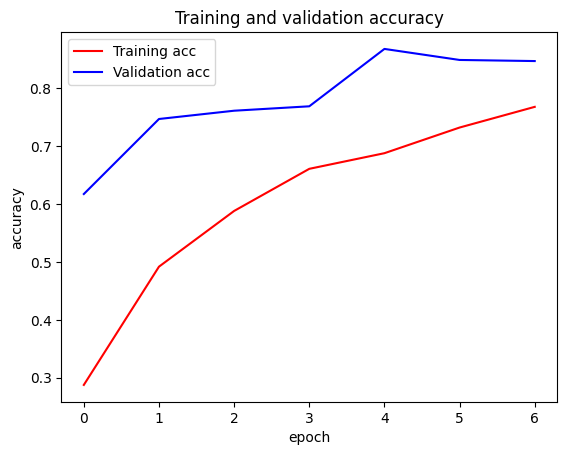

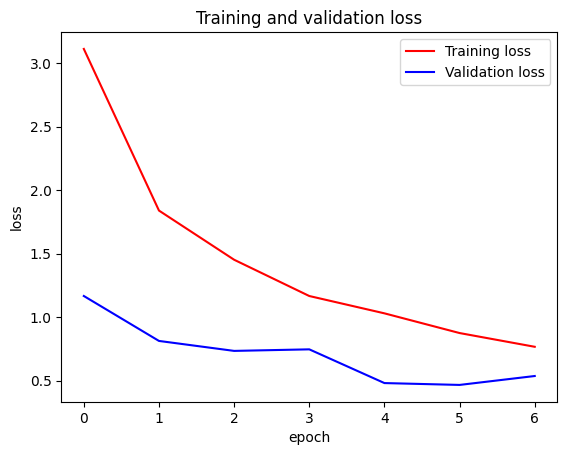

In [ ]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data, test_labels)

99/99 [==============================] - 1s 9ms/step - loss: 1.0233 - acc: 0.7222


[1.0232899188995361, 0.7222222089767456]

## Kiểm thử các giá trị đo độ chính xác cho các nhãn

In [ ]:
## sử dụng mô hình huấn luyện bên trên để dự đoán các nhãn cho tập test_data
preds = np.round(model.predict(test_data),0)
print('test_labels', preds)

99/99 [==============================] - 2s 16ms/step
test_labels [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
animals = ['Bọ cánh cứng', 'Butterfly', 'Cat', 'Chuot', 'Cow', 'Dog','Hama','Ho','Khi','NguaVan','Nhen','Panda','Thanlan','TinhTInh','Voi']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

Bọ cánh cứng       0.86      0.37      0.52       210
   Butterfly       0.71      0.80      0.76       210
         Cat       0.62      0.92      0.74       210
       Chuot       0.71      0.40      0.51       210
         Cow       0.54      0.82      0.65       210
         Dog       0.94      0.66      0.77       210
        Hama       0.73      0.72      0.73       210
          Ho       0.74      0.83      0.78       210
         Khi       0.88      0.29      0.43       210
     NguaVan       0.97      0.45      0.62       210
        Nhen       0.96      0.94      0.95       210
       Panda       0.90      0.69      0.78       210
     Thanlan       0.91      0.74      0.82       210
    TinhTInh       1.00      0.30      0.46       210
         Voi       0.95      0.65      0.77       210

   micro avg       0.78      0.64      0.70      3150
   macro avg       0.83      0.64      0.69      3150
weighted avg       0.83   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Chạy mô hình với ảnh test đầu vào

In [ ]:
## đọc ảnh, resize 224*224
def read_image(file_path):
    image = load_img(file_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.
    return image

In [ ]:
import os

def get_subdirectory_labels(main_directory_path):
    labels = []
    for root, dirs, files in os.walk(main_directory_path):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            if os.path.isdir(dir_path):
                labels.append(dir)
    return sorted(labels)

# Example usage
main_directory_path = "/content/drive/MyDrive/Data_cdhttt/validation"
all_labels = get_subdirectory_labels(main_directory_path)
print(all_labels)

['Bò', 'Bọ cánh cứng', 'Bươm bướm', 'Chó', 'Chuột', 'Gấu trúc', 'Hà mã', 'Hổ', 'Khỉ', 'Mèo', 'Ngựa vằn', 'Nhện', 'Thằn lằn', 'Tinh tinh', 'Voi']


In [ ]:
def test_single_image(path):
  animals = ['Bò', 'Bọ cánh cứng', 'Bươm bướm', 'Chó', 'Chuột', 'Gấu trúc', 'Hà mã', 'Hổ', 'Khỉ', 'Mèo', 'Ngựa vằn', 'Nhện', 'Thằn lằn', 'Tinh tinh', 'Voi']
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images)
  preds = model.predict(bt_prediction)
  for idx, animal, x in zip(range(0,15), animals , preds[0]):
      print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
  print('Final Decision:')
  time.sleep(.5)
  predicted_class = np.argmax(preds[0])
  class_dictionary = generator_top.class_indices
  inv_map = {v: k for k, v in class_dictionary.items()}
  print("ID: {}, Label: {}".format(predicted_class, inv_map[predicted_class]))
  return load_img(path)

In [ ]:
path = '/content/drive/MyDrive/Data_cdhttt/validation/Nhện/Spider-Train (379).jpeg'

1/1 [==============================] - 0s 26ms/step
ID: 0, Label: Bò 0.0%
ID: 1, Label: Bọ cánh cứng 0.13%
ID: 2, Label: Bươm bướm 4.4%
ID: 3, Label: Chó 0.0%
ID: 4, Label: Chuột 0.01%
ID: 5, Label: Gấu trúc 0.0%
ID: 6, Label: Hà mã 0.0%
ID: 7, Label: Hổ 0.0%
ID: 8, Label: Khỉ 0.0%
ID: 9, Label: Mèo 0.0%
ID: 10, Label: Ngựa vằn 0.0%
ID: 11, Label: Nhện 95.46%
ID: 12, Label: Thằn lằn 0.0%
ID: 13, Label: Tinh tinh 0.0%
ID: 14, Label: Voi 0.0%
Final Decision:
ID: 11, Label: Nhện


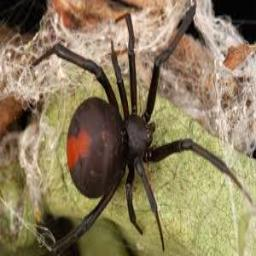

In [ ]:
test_single_image(path)